In [83]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn import linear_model
import sklearn.metrics as metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2
from plotnine import *
import scienceplots
plt.style.use(['science','nature', 'no-latex'])

import sys
sys.path.append('../src')
sys.path.append('../slicefinder')
import utils
from stability_analysis import LatentSubgroupShiftEstimator
from clustering_analysis import ClusteringEstimator
import sirus
import subprocess
from slice_finder import SliceFinder
from statsmodels.stats.weightstats import ztest, ttest_ind


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Synthetic Data

In [6]:
def sigmoid(x):
    return(1./(1. + np.exp(-x)))

def generate_data(n=10000, dim=10, cardinality=2):
    # categorical data
    # for now let's assume binary
    if cardinality > 2:
        raise NotImplementedError("Currently only supports binary features 'cardinality == 2'")
    X = np.random.randint(low=0, high=cardinality, size=(n, dim))
    # bernoulli to rademacher
    X = 2*X - 1
    
    logit = 1.6 * X[:, 0] + 1.4 * X[:, 2] + 1.2 * X[:, 3]
    probs = sigmoid(logit)
    y = np.random.binomial(1, probs)
    
    return X, y

def generate_random_data(n=10000, dim=10, features=None, coeffs=None, cardinality=2):
    if cardinality > 2:
        raise NotImplementedError("Currently only supports binary features 'cardinality == 2'")
    X = np.random.randint(low=0, high=cardinality, size=(n, dim))
    # bernoulli to rademacher
    X = 2*X - 1

    if features is None:
        num_relevant_features = max(1, min(np.random.poisson(3), dim))
        features = sorted(np.random.choice(range(dim), num_relevant_features, replace=False))
    if coeffs is None:
        signs = np.random.binomial(1, 0.6, num_relevant_features)
        signs = 2*signs - 1
        # signs *= 2
        coeffs = np.random.randn(num_relevant_features)*0.5**2 + signs
    print(coeffs)
    logit = np.dot(X[:, features], coeffs)
    probs = sigmoid(logit)
    y = np.random.binomial(1, probs)
    
    return X, y

In [7]:
# measure performance
# Recall, precision, FDR
def ground_truth_performance(true_mask, rules, df):
    if len(rules) > 0:
        
        masks = []
        for rule in rules:
            masks.append(df.eval(rule))
        
        estimated_mask = masks[0]
        for i in range(1, len(masks)):
            estimated_mask = estimated_mask | masks[i]
    else:
        estimated_mask = true_mask & False
        return(0, 0, 0)
    
    # recall
    true_inds = true_mask == True
    recall = (true_mask[true_inds] == estimated_mask[true_inds]).mean()

    # precision
    pred_pos_inds = estimated_mask == True
    precision = (true_mask[pred_pos_inds] == estimated_mask[pred_pos_inds]).mean()

    fdr = 1 - precision

    return(recall, precision, fdr)

In [8]:
def run_clustering(X_test, test_loss, subgroup_mask, depth=2):
    cl = ClusteringEstimator(verbose=False)
    cl.fit(X_test, test_loss)
    
    phenotype_df = pd.DataFrame(X_test)
    phenotype_df = phenotype_df.add_prefix('X')
    
    phenotype_df['subset_label'] = cl.masks_*1
    
    df_fname = f"tmp/cl_ground_truth.csv"
    
    phenotype_df.to_csv(df_fname, index=False)

    print("Running Clustering")
    cl_rules_fname = f"tmp/groundtruth_cl_rules.txt"
    subprocess.call((f"/home/adarsh.subbaswamy/anaconda3/envs/afisp/bin/Rscript" 
    f" run_sirus.r" 
    f" --input {df_fname} "
    f" --output {cl_rules_fname}"
    f" --depth {depth}"
    f" "),
    shell=True)
    
    cl_rules = sirus.get_sirus_rules(cl_rules_fname)
    cl_rule_p_values = sirus.precompute_p_values(cl_rules, phenotype_df, test_loss)
    cl_significant_rules = sirus.holm_bonferroni_correction(cl_rule_p_values)
    
    cl_extracted_rules = sirus.effect_size_filtering(cl_significant_rules, phenotype_df, test_loss, 
                                                  effect_threshold=0.4)
    
    cl_recall, cl_precision, cl_fdr = ground_truth_performance(subgroup_mask, 
                                                               cl_extracted_rules, 
                                                               phenotype_df)
    cl_recall_top, cl_precision_top, cl_fdr_top = ground_truth_performance(subgroup_mask, 
                                                           cl_extracted_rules[0:1], 
                                                           phenotype_df)

    return(( cl_recall, cl_precision, cl_fdr), (cl_recall_top, cl_precision_top, cl_fdr_top))

In [9]:
# Correctly specified
def well_specified(plot=True, misspecified=False, depth=2):
    # X, y = generate_data(50000)
    X_all, y_all = generate_random_data(60000)
    X = X_all[:50000]
    y = y_all [:50000]

    model = linear_model.LogisticRegression(C=1e6, fit_intercept=False)
    model.fit(X, y)

    X_test = X_all[50000:]
    y_test = y_all[50000:]
    # X_test, y_test = generate_data(10000)

    subgroup_mask =  (X_test[:, 2] == -1) & (X_test[:, 3] == 1)
    if misspecified:
        subgroup_mask = (X_test[:, 8] == 1) & (X_test[:, 2] == -1) & (X_test[:, 3] == 1)
    
    print(f"Subgroup size is {sum(subgroup_mask)/len(y_test):.1%}")

    flipped_inds = []
    for i in range(len(y_test)):
        if subgroup_mask[i]:
            if np.random.binomial(1, 0.5) == 1:
                if y_test[i] == 1:
                    y_test[i] = 0
                else:
                    y_test[i] = 1
                flipped_inds.append(i)
            
    test_preds = model.predict_proba(X_test)[:, 1]

    print(f"Avg Brier Score on Dataset = {metrics.brier_score_loss(y_test, test_preds):.3f}")
    print(f"Brier Score in Subgroup = {metrics.brier_score_loss(y_test[subgroup_mask], test_preds[subgroup_mask]):.3f}")
    print(f"Brier Score out of Subgroup = {metrics.brier_score_loss(y_test[~subgroup_mask], test_preds[~subgroup_mask]):.3f}")

    loss_fn = utils.brier
    test_loss = loss_fn(y_test, test_preds)
    phenotype_df = pd.DataFrame(X_test)
    phenotype_df = phenotype_df.add_prefix('X')
    # adding noise (eps > 0) because most of our features are discrete
    stability_analysis = LatentSubgroupShiftEstimator(cv=5,
                                                     verbose=False,
                                                     eps=1e-5,
                                                     subset_fractions=np.arange(0.05, 1, 0.05))
    sa_risks = stability_analysis.fit(X_test, test_loss, feature_names=list(phenotype_df.columns))
    print("done fitting worst-case")
    sa_masks = stability_analysis.subset_masks()
    if plot:
        # can also compute bootstrap confidence intervals
        bootstrap_cis = np.zeros((len(sa_masks), 2))
        for i, alpha in tqdm(enumerate(stability_analysis.subset_fractions)):
            mask = sa_masks[i]
            mean, upper, lower = utils.bootstrap_ci(y_test[mask], 
                                                    test_preds[mask], 
                                                    loss=metrics.brier_score_loss)
            bootstrap_cis[i, 0] = lower
            bootstrap_cis[i, 1] = upper
    
        plt.plot(stability_analysis.subset_fractions, np.array(sa_risks))
        plt.fill_between(stability_analysis.subset_fractions,
                         bootstrap_cis[:, 0], 
                         bootstrap_cis[:, 1], 
                         alpha=0.25, 
                         label='Bootstrap')
        plt.xlabel('Subset Fraction')
        plt.ylabel('Brier Score')
        plt.legend(loc='best')
        plt.show()


    cds = []
    p_vals = []
    
    for i, a in enumerate(stability_analysis.subset_fractions):
        idxs = sa_masks[i]
        odxs = ~sa_masks[i]
        cds.append(sirus.cohens_d(test_loss[idxs], test_loss[odxs]))
        pval = ttest_ind(test_loss[idxs], 
                             x2=test_loss[odxs], 
                             value=0.,
                             alternative='larger',
                             usevar='unequal')[1]
        p_vals.append(pval)
        
    if plot:
        plt.plot(stability_analysis.subset_fractions, cds)
        plt.xlabel('Subset Fraction')
        plt.ylabel('Cohens d (Effect Size)')
        plt.show()

    max_ind, max_cd = sirus.find_max_effect_size(sa_masks, test_loss)
    print(max_ind, stability_analysis.subset_fractions[max_ind], max_cd)

    
    phenotype_df['subset_label'] = sa_masks[max_ind]*1
    
    df_fname = f"tmp/ground_truth.csv"
    
    phenotype_df.to_csv(df_fname, index=False)
    print("AFISP")
    sirus_rules_fname = f"tmp/groundtruth_sirus_rules.txt"
    subprocess.call((f"/home/adarsh.subbaswamy/anaconda3/envs/afisp/bin/Rscript" 
    f" run_sirus.r" 
    f" --input {df_fname} "
    f" --output {sirus_rules_fname}"
    f" --depth {depth}"
    f" "), # --cv
    shell=True)

    
    sirus_rules = sirus.get_sirus_rules(sirus_rules_fname)
    rule_p_values = sirus.precompute_p_values(sirus_rules, phenotype_df, test_loss)
    significant_rules = sirus.holm_bonferroni_correction(rule_p_values)
    
    extracted_rules = sirus.effect_size_filtering(significant_rules, phenotype_df, test_loss, 
                                                  effect_threshold=0.4)
    afisp_recall, afisp_precision, afisp_fdr = ground_truth_performance(subgroup_mask, 
                                                                        extracted_rules, 
                                                                        phenotype_df)
    afisp_recall_top, afisp_precision_top, afisp_fdr_top = ground_truth_performance(subgroup_mask, 
                                                                        extracted_rules[0:1], 
                                                                        phenotype_df)
    (cl_recall, cl_precision, cl_fdr), ( cl_recall_top, cl_precision_top, cl_fdr_top) = run_clustering(X_test, 
                                                                                                       test_loss,
                                                                                                       subgroup_mask,
                                                                                                       depth
                                                                                                      )
    
    sfX = pd.DataFrame(X_test)
    sfX = sfX.add_prefix('X')
    sf = SliceFinder(model, (sfX, pd.DataFrame({'y': y_test})))
    d1_slices = sf.slicing()
    d2_slices = sf.crossing(d1_slices, 2)
    candidate_slices = d1_slices + d2_slices
    candidate_rules = [sirus.slice_to_equality_rule(s) for s in candidate_slices]
    
    rule_p_values = sirus.precompute_p_values(candidate_rules, sfX, test_loss)
    significant_rules = sirus.holm_bonferroni_correction(rule_p_values)
    
    sf_extracted_rules = sirus.effect_size_filtering(significant_rules, sfX, test_loss, 
                                                  effect_threshold=0.4)

    sf_recall, sf_precision, sf_fdr = ground_truth_performance(subgroup_mask, 
                                                                        sf_extracted_rules, 
                                                                        phenotype_df)
    sf_recall_top, sf_precision_top, sf_fdr_top = ground_truth_performance(subgroup_mask, 
                                                                        sf_extracted_rules[0:1], 
                                                                        phenotype_df)

    
    # recommendations = sf.find_slice(k=100, epsilon=0.2, degree=depth, max_workers=32)
    # sf_rules = [sirus.slice_to_equality_rule(s) for s in recommendations]

    # sf_recall, sf_precision, sf_fdr = ground_truth_performance(subgroup_mask, 
    #                                                            sf_rules,
    #                                                            phenotype_df)
    # sf_recall_top, sf_precision_top, sf_fdr_top = ground_truth_performance(subgroup_mask, 
    #                                                        sf_rules[0:1],
    #                                                        phenotype_df)

    print(afisp_recall, afisp_precision)
    print(sf_recall, sf_precision)
    print(cl_recall, cl_precision)

    return((afisp_recall, afisp_precision), 
           (sf_recall, sf_precision), 
           (cl_recall, cl_precision),
           (afisp_recall_top, afisp_precision_top), 
           (sf_recall_top, sf_precision_top), 
           (cl_recall_top, cl_precision_top)
          )

In [10]:
num_iters = 50

recalls = []
precisions = []
top_recalls = []
top_precisions = []
methods = []
iters = []

for i in tqdm(range(num_iters)):
    a_res, s_res, c_res, a_res_top, s_res_top, c_res_top = well_specified(False)
    recalls += [a_res[0], s_res[0], c_res[0]]
    precisions += [a_res[1], s_res[1], c_res[1]]
    top_recalls += [a_res_top[0], s_res_top[0], c_res_top[0]]
    top_precisions += [a_res_top[1], s_res_top[1], c_res_top[1]]
    methods += ['AFISP', 'SliceFinder', 'Clustering']
    iters += [i, i, i]

  0%|                                                                                                         | 0/50 [00:00<?, ?it/s]

[0.65730985 0.81546643 0.88371288]
Subgroup size is 25.4%
Avg Brier Score on Dataset = 0.217
Brier Score in Subgroup = 0.320
Brier Score out of Subgroup = 0.182
done fitting worst-case
16 0.8500000000000001 0.6855733729042168
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.92  %."
[1] "Number of trees:  2000  - Stability  93.7  %."
[1] "Number of trees:  3000  - Stability  94.43  %."
[1] "Number of trees:  4000  - Stability  94.87  %."
[1] "Number of trees:  5000  - Stability  95.44  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 149.73it/s]


5 ('X8 >= 1', 0.02397436865894105, 5016) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 161.59it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.32  %."
[1] "Number of trees:  2000  - Stability  92.6  %."
[1] "Number of trees:  3000  - Stability  93.9  %."
[1] "Number of trees:  4000  - Stability  94.42  %."
[1] "Number of trees:  5000  - Stability  94.65  %."
[1] "Number of trees:  6000  - Stability  94.87  %."
[1] "Number of trees:  7000  - Stability  95.21  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 140.05it/s]


5 ('X5 >= 1', 0.30031929909828925, 5056) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 176.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 164.34it/s]


42 ('(X5 == 1) and (X8 == 1)', 0.007273842797540529, 2546) 0.0002958579881656805



  2%|█▉                                                                                               | 1/50 [00:44<35:57, 44.04s/it]

0 0
1.0 1.0
0 0
[1.0174135  0.42365344]
Subgroup size is 25.3%
Avg Brier Score on Dataset = 0.221
Brier Score in Subgroup = 0.305
Brier Score out of Subgroup = 0.192
done fitting worst-case
4 0.25 0.5268488424783976
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.56  %."
[1] "Number of trees:  2000  - Stability  92.77  %."
[1] "Number of trees:  3000  - Stability  93.7  %."
[1] "Number of trees:  4000  - Stability  94.17  %."
[1] "Number of trees:  5000  - Stability  94.85  %."
[1] "Number of trees:  6000  - Stability  95.09  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 165.70it/s]


6 ('X7 >= 1', 0.17447374134707822, 4959) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 167.23it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.85  %."
[1] "Number of trees:  2000  - Stability  91.21  %."
[1] "Number of trees:  3000  - Stability  92.73  %."
[1] "Number of trees:  4000  - Stability  92.38  %."
[1] "Number of trees:  5000  - Stability  93.68  %."
[1] "Number of trees:  6000  - Stability  93.54  %."
[1] "Number of trees:  7000  - Stability  93.84  %."
[1] "Number of trees:  8000  - Stability  94.15  %."
[1] "Number of trees:  9000  - Stability  94.8  %."
[1] "Number of trees:  10000  - Stability  94.69  %."
[1] "Number of trees:  11000  - Stability  95.04  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 168.59it/s]


6 ('X7 >= 1', 0.17447374134707822, 4959) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 190.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 185.51it/s]


39 ('(X5 == 1) and (X8 == 1)', 0.03654129241651203, 2540) 0.00029069767441860465



  4%|███▉                                                                                             | 2/50 [01:08<26:05, 32.61s/it]

0 0
1.0 1.0
0 0
[1.23673885 1.35800221]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.205
Brier Score in Subgroup = 0.352
Brier Score out of Subgroup = 0.157
done fitting worst-case
1 0.1 1.272563006087717
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.64  %."
[1] "Number of trees:  2000  - Stability  93.11  %."
[1] "Number of trees:  3000  - Stability  94.02  %."
[1] "Number of trees:  4000  - Stability  94.45  %."
[1] "Number of trees:  5000  - Stability  95.01  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 163.62it/s]


9 ('X8 < 1', 0.22315164993901693, 4998) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 171.37it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.27  %."
[1] "Number of trees:  2000  - Stability  91.99  %."
[1] "Number of trees:  3000  - Stability  93  %."
[1] "Number of trees:  4000  - Stability  94.05  %."
[1] "Number of trees:  5000  - Stability  94.7  %."
[1] "Number of trees:  6000  - Stability  95.12  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.98it/s]


7 ('X8 < 1', 0.22315164993901693, 4998) 0.016666666666666666



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 170.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 207.09it/s]


53 ('(X8 == -1) and (X9 == -1)', 0.02923262696439493, 2483) 0.00031645569620253165



  6%|█████▊                                                                                           | 3/50 [01:33<22:40, 28.94s/it]

1.0 0.28604118993135014
1.0 0.28604118993135014
1.0 0.3349859305909152
[-0.59962237  1.00303407 -0.75682377]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.215
Brier Score in Subgroup = 0.316
Brier Score out of Subgroup = 0.181
done fitting worst-case
16 0.8500000000000001 0.6505311514925175
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.46  %."
[1] "Number of trees:  2000  - Stability  93.63  %."
[1] "Number of trees:  3000  - Stability  94.04  %."
[1] "Number of trees:  4000  - Stability  94.55  %."
[1] "Number of trees:  5000  - Stability  94.9  %."
[1] "Number of trees:  6000  - Stability  95.43  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 159.89it/s]


6 ('X0 < 1', 0.10537191506155356, 4997) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 182.83it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.04  %."
[1] "Number of trees:  2000  - Stability  92.25  %."
[1] "Number of trees:  3000  - Stability  93.32  %."
[1] "Number of trees:  4000  - Stability  93.81  %."
[1] "Number of trees:  5000  - Stability  94.46  %."
[1] "Number of trees:  6000  - Stability  94.94  %."
[1] "Number of trees:  7000  - Stability  95.43  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 174.36it/s]


5 ('X9 >= 1', 0.4400941671547711, 4969) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 199.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 173.17it/s]


41 ('(X5 == -1) and (X8 == 1)', 0.015251483141616229, 2526) 0.00029411764705882356



  8%|███████▊                                                                                         | 4/50 [01:57<20:54, 27.26s/it]

0 0
1.0 1.0
0 0
[1.27987803 0.65841237 0.72920539]
Subgroup size is 24.8%
Avg Brier Score on Dataset = 0.206
Brier Score in Subgroup = 0.332
Brier Score out of Subgroup = 0.165
done fitting worst-case
0 0.05 0.9131450519788578
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.41  %."
[1] "Number of trees:  2000  - Stability  94.5  %."
[1] "Number of trees:  3000  - Stability  95.23  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 172.38it/s]


9 ('X6 >= 1', 0.3746195017416603, 5064) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 192.44it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.05  %."
[1] "Number of trees:  2000  - Stability  92.83  %."
[1] "Number of trees:  3000  - Stability  93.97  %."
[1] "Number of trees:  4000  - Stability  94.54  %."
[1] "Number of trees:  5000  - Stability  94.91  %."
[1] "Number of trees:  6000  - Stability  95.36  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 150.79it/s]


6 ('X8 < 1', 0.30929699983413045, 5072) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 154.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 199.10it/s]


61 ('(X1 == -1) and (X4 == 1)', 0.00035868104956910795, 2505) 0.0003333333333333334



 10%|█████████▋                                                                                       | 5/50 [02:22<19:38, 26.19s/it]

1.0 0.6623965839338137
1.0 0.562684198594423
0.4935535858178888 0.48438117833135624
[1.22573454 1.36965122 1.23376483]
Subgroup size is 25.1%
Avg Brier Score on Dataset = 0.188
Brier Score in Subgroup = 0.354
Brier Score out of Subgroup = 0.132
done fitting worst-case
4 0.25 0.8406245660983653
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.44  %."
[1] "Number of trees:  2000  - Stability  94.35  %."
[1] "Number of trees:  3000  - Stability  95.11  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 167.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 201.87it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.61  %."
[1] "Number of trees:  2000  - Stability  92.25  %."
[1] "Number of trees:  3000  - Stability  93.11  %."
[1] "Number of trees:  4000  - Stability  94.25  %."
[1] "Number of trees:  5000  - Stability  94.59  %."
[1] "Number of trees:  6000  - Stability  94.74  %."
[1] "Number of trees:  7000  - Stability  95.16  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 172.47it/s]


6 ('X5 >= 1', 0.03348254585062677, 5097) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 173.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 169.79it/s]


52 ('(X0 == -1) and (X9 == -1)', 0.00032553600770397913, 2509) 0.0003144654088050315



 12%|███████████▋                                                                                     | 6/50 [02:47<18:57, 25.86s/it]

1.0 0.3356531049250535
1.0 0.3356531049250535
1.0 0.5066666666666667
[-1.15490471 -1.18628878]
Subgroup size is 24.6%
Avg Brier Score on Dataset = 0.203
Brier Score in Subgroup = 0.327
Brier Score out of Subgroup = 0.162
done fitting worst-case
1 0.1 1.0724345865772755
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.6  %."
[1] "Number of trees:  2000  - Stability  93.44  %."
[1] "Number of trees:  3000  - Stability  94.08  %."
[1] "Number of trees:  4000  - Stability  94.46  %."
[1] "Number of trees:  5000  - Stability  94.7  %."
[1] "Number of trees:  6000  - Stability  95.51  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 160.61it/s]


9 ('X4 >= 1', 0.053686929031429194, 4946) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 174.93it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.94  %."
[1] "Number of trees:  2000  - Stability  92.44  %."
[1] "Number of trees:  3000  - Stability  94.02  %."
[1] "Number of trees:  4000  - Stability  94.81  %."
[1] "Number of trees:  5000  - Stability  94.75  %."
[1] "Number of trees:  6000  - Stability  95.02  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 156.41it/s]


5 ('X4 >= 1 & X5 < 1', 0.025976650905999363, 2500) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 154.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 190.18it/s]


53 ('(X4 == 1) and (X7 == 1)', 0.014699674192528375, 2489) 0.00031645569620253165



 14%|█████████████▌                                                                                   | 7/50 [03:12<18:20, 25.59s/it]

1.0 0.6673901247965274
1.0 0.6673901247965274
0 0
[-0.73335943 -0.90767402  1.55483011]
Subgroup size is 24.1%
Avg Brier Score on Dataset = 0.194
Brier Score in Subgroup = 0.363
Brier Score out of Subgroup = 0.140
done fitting worst-case
1 0.1 0.9737840952449498
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.59  %."
[1] "Number of trees:  2000  - Stability  94.51  %."
[1] "Number of trees:  3000  - Stability  95.4  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 163.94it/s]


9 ('X8 < 1', 0.10241315882581417, 4999) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 190.52it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.53  %."
[1] "Number of trees:  2000  - Stability  91.47  %."
[1] "Number of trees:  3000  - Stability  92.88  %."
[1] "Number of trees:  4000  - Stability  93.96  %."
[1] "Number of trees:  5000  - Stability  94.27  %."
[1] "Number of trees:  6000  - Stability  94.92  %."
[1] "Number of trees:  7000  - Stability  95.24  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 154.93it/s]


5 ('X0 >= 1', 0.34343250131753056, 5011) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 153.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 189.22it/s]


50 ('(X2 == 1) and (X5 == 1)', 0.0032014117666525933, 2514) 0.00031055900621118014



 16%|███████████████▌                                                                                 | 8/50 [03:36<17:35, 25.13s/it]

1.0 0.392862962359459
1.0 0.392862962359459
0 0
[ 1.21904272  0.99725572 -1.13531698]
Subgroup size is 25.3%
Avg Brier Score on Dataset = 0.204
Brier Score in Subgroup = 0.360
Brier Score out of Subgroup = 0.152
done fitting worst-case
4 0.25 0.7925148736337925
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.57  %."
[1] "Number of trees:  2000  - Stability  92.88  %."
[1] "Number of trees:  3000  - Stability  93.54  %."
[1] "Number of trees:  4000  - Stability  94.48  %."
[1] "Number of trees:  5000  - Stability  94.95  %."
[1] "Number of trees:  6000  - Stability  95.68  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 164.86it/s]


7 ('X4 < 1', 0.10705547152023345, 4995) 0.016666666666666666



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 163.79it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.5  %."
[1] "Number of trees:  2000  - Stability  93.86  %."
[1] "Number of trees:  3000  - Stability  94.87  %."
[1] "Number of trees:  4000  - Stability  95.2  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 148.07it/s]


5 ('X1 >= 1', 0.10499722246783935, 4968) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 158.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 169.00it/s]


41 ('(X7 == 1) and (X9 == 1)', 0.0010232543785605292, 2531) 0.00029411764705882356



 18%|█████████████████▍                                                                               | 9/50 [04:01<17:10, 25.13s/it]

1.0 0.5045944866160608
1.0 0.5045944866160608
1.0 0.5045944866160608
[ 1.27673335 -1.13144966]
Subgroup size is 25.5%
Avg Brier Score on Dataset = 0.205
Brier Score in Subgroup = 0.334
Brier Score out of Subgroup = 0.160
done fitting worst-case
11 0.6000000000000001 0.9410560388616304
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.94  %."
[1] "Number of trees:  2000  - Stability  93.18  %."
[1] "Number of trees:  3000  - Stability  94.24  %."
[1] "Number of trees:  4000  - Stability  95.05  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 164.76it/s]


6 ('X7 >= 1', 0.07751072379669988, 4955) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 191.31it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  87.31  %."
[1] "Number of trees:  2000  - Stability  89.11  %."
[1] "Number of trees:  3000  - Stability  91.09  %."
[1] "Number of trees:  4000  - Stability  92.32  %."
[1] "Number of trees:  5000  - Stability  92.97  %."
[1] "Number of trees:  6000  - Stability  92.86  %."
[1] "Number of trees:  7000  - Stability  93.36  %."
[1] "Number of trees:  8000  - Stability  93.61  %."
[1] "Number of trees:  9000  - Stability  94.1  %."
[1] "Number of trees:  10000  - Stability  94.47  %."
[1] "Number of trees:  11000  - Stability  94.83  %."
[1] "Number of trees:  12000  - Stability  94.81  %."
[1] "Number of trees:  13000  - Stability  94.92  %."
[1] "Number of trees:  14000  - Stability  95.14  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 171.01it/s]


2 ('X7 >= 1', 0.07751072379669988, 4955) 0.005555555555555556



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 172.02it/s]


39 ('(X1 == 1)', 0.004231255245854352, 4943) 0.00029069767441860465



 20%|███████████████████▏                                                                            | 10/50 [04:26<16:40, 25.02s/it]

1.0 1.0
1.0 1.0
0 0
[0.89029365 1.42049229 0.60636062]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.169
Brier Score in Subgroup = 0.286
Brier Score out of Subgroup = 0.130
done fitting worst-case
7 0.4 0.8077946620873088
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.72  %."
[1] "Number of trees:  2000  - Stability  93.14  %."
[1] "Number of trees:  3000  - Stability  94.27  %."
[1] "Number of trees:  4000  - Stability  94.58  %."
[1] "Number of trees:  5000  - Stability  95.01  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 180.57it/s]


6 ('X5 >= 1', 0.0372339784708993, 5017) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 191.34it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  88.72  %."
[1] "Number of trees:  2000  - Stability  92.26  %."
[1] "Number of trees:  3000  - Stability  93.92  %."
[1] "Number of trees:  4000  - Stability  94.94  %."
[1] "Number of trees:  5000  - Stability  95.14  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 165.12it/s]


6 ('X5 >= 1', 0.0372339784708993, 5017) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 188.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 122.39it/s]


49 ('(X3 == 1) and (X4 == -1)', 0.0003548448393317739, 2497) 0.00030864197530864197



 22%|█████████████████████                                                                           | 11/50 [04:51<16:13, 24.96s/it]

0 0
1.0 1.0
1.0 1.0
[-0.83054488]
Subgroup size is 24.5%
Avg Brier Score on Dataset = 0.232
Brier Score in Subgroup = 0.295
Brier Score out of Subgroup = 0.212
done fitting worst-case
3 0.2 0.4575743917756199
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.28  %."
[1] "Number of trees:  2000  - Stability  94.08  %."
[1] "Number of trees:  3000  - Stability  95.18  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 163.89it/s]


9 ('X7 < 1', 0.11081078783417424, 4975) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 199.29it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  87.81  %."
[1] "Number of trees:  2000  - Stability  90.08  %."
[1] "Number of trees:  3000  - Stability  91.29  %."
[1] "Number of trees:  4000  - Stability  92.5  %."
[1] "Number of trees:  5000  - Stability  92.51  %."
[1] "Number of trees:  6000  - Stability  92.95  %."
[1] "Number of trees:  7000  - Stability  93  %."
[1] "Number of trees:  8000  - Stability  93.27  %."
[1] "Number of trees:  9000  - Stability  93.31  %."
[1] "Number of trees:  10000  - Stability  93.55  %."
[1] "Number of trees:  11000  - Stability  93.72  %."
[1] "Number of trees:  12000  - Stability  94.12  %."
[1] "Number of trees:  13000  - Stability  94.33  %."
[1] "Number of trees:  14000  - Stability  94.64  %."
[1] "Number of trees:  15000  - Stability  94.95  %."
[1] "Number of trees:  16000  - Stability  95.25  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 153.02it/s]


2 ('X9 >= 1', 0.01656656482299924, 4887) 0.005555555555555556



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 168.56it/s]


37 ('(X0 == 1) and (X9 == 1)', 0.010482531115307617, 2433) 0.00028735632183908046



 24%|███████████████████████                                                                         | 12/50 [05:15<15:41, 24.78s/it]

1.0 1.0
1.0 1.0
0 0
[1.37177206]
Subgroup size is 24.9%
Avg Brier Score on Dataset = 0.209
Brier Score in Subgroup = 0.346
Brier Score out of Subgroup = 0.163
done fitting worst-case
4 0.25 0.6955051334970197
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.99  %."
[1] "Number of trees:  2000  - Stability  93.82  %."
[1] "Number of trees:  3000  - Stability  94.98  %."
[1] "Number of trees:  4000  - Stability  95.55  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 164.02it/s]


6 ('X0 < 1', 0.20913346951475587, 4946) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 183.68it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.17  %."
[1] "Number of trees:  2000  - Stability  92.85  %."
[1] "Number of trees:  3000  - Stability  93.79  %."
[1] "Number of trees:  4000  - Stability  94.25  %."
[1] "Number of trees:  5000  - Stability  94.95  %."
[1] "Number of trees:  6000  - Stability  95.22  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 152.73it/s]


5 ('X0 < 1 & X9 >= 1', 0.019638768968962245, 2479) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 174.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 176.02it/s]


37 ('(X8 == -1)', 0.0035618354549551883, 4994) 0.00028735632183908046



 26%|████████████████████████▉                                                                       | 13/50 [05:40<15:14, 24.72s/it]

1.0 1.0
1.0 1.0
0 0
[ 1.64396609  0.69247539  1.26794652 -1.05613585 -1.13101787  0.90220749
  1.07385435]
Subgroup size is 25.1%
Avg Brier Score on Dataset = 0.184
Brier Score in Subgroup = 0.396
Brier Score out of Subgroup = 0.113
done fitting worst-case
4 0.25 1.0490771876955716
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.28  %."
[1] "Number of trees:  2000  - Stability  92.53  %."
[1] "Number of trees:  3000  - Stability  93.57  %."
[1] "Number of trees:  4000  - Stability  94  %."
[1] "Number of trees:  5000  - Stability  94.42  %."
[1] "Number of trees:  6000  - Stability  94.89  %."
[1] "Number of trees:  7000  - Stability  95.13  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 166.10it/s]


4 ('X1 < 1', 0.007592140257584344, 4941) 0.0071428571428571435



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.90it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.91  %."
[1] "Number of trees:  2000  - Stability  94.72  %."
[1] "Number of trees:  3000  - Stability  96.03  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 168.24it/s]


5 ('X8 < 1', 0.13592419308169393, 5058) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 165.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 164.40it/s]


39 ('(X5 == 1) and (X9 == 1)', 0.005049695027585973, 2559) 0.00029069767441860465



 28%|██████████████████████████▉                                                                     | 14/50 [06:05<14:50, 24.74s/it]

1.0 0.336096256684492
1.0 0.336096256684492
1.0 0.49900754267566494
[-1.24422158]
Subgroup size is 23.9%
Avg Brier Score on Dataset = 0.210
Brier Score in Subgroup = 0.325
Brier Score out of Subgroup = 0.173
done fitting worst-case
3 0.2 0.6120576415917459
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.67  %."
[1] "Number of trees:  2000  - Stability  93.36  %."
[1] "Number of trees:  3000  - Stability  94.81  %."
[1] "Number of trees:  4000  - Stability  95.28  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 167.36it/s]


9 ('X4 >= 1', 0.03821083229013352, 4992) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 198.16it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.28  %."
[1] "Number of trees:  2000  - Stability  92.81  %."
[1] "Number of trees:  3000  - Stability  94.35  %."
[1] "Number of trees:  4000  - Stability  94.97  %."
[1] "Number of trees:  5000  - Stability  95.64  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 170.38it/s]


5 ('X4 >= 1', 0.03821083229013352, 4992) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 155.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 170.89it/s]


37 ('(X6 == 1) and (X8 == -1)', 0.0028415949671741587, 2527) 0.00028735632183908046



 30%|████████████████████████████▊                                                                   | 15/50 [06:28<14:16, 24.46s/it]

1.0 1.0
1.0 1.0
0 0
[-0.72561948 -0.91166195 -1.29437742 -0.79399421]
Subgroup size is 24.8%
Avg Brier Score on Dataset = 0.204
Brier Score in Subgroup = 0.362
Brier Score out of Subgroup = 0.152
done fitting worst-case
4 0.25 0.8434262315165506
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.44  %."
[1] "Number of trees:  2000  - Stability  92.58  %."
[1] "Number of trees:  3000  - Stability  93.37  %."
[1] "Number of trees:  4000  - Stability  94.1  %."
[1] "Number of trees:  5000  - Stability  94.22  %."
[1] "Number of trees:  6000  - Stability  94.25  %."
[1] "Number of trees:  7000  - Stability  94.87  %."
[1] "Number of trees:  8000  - Stability  95.19  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 160.67it/s]


9 ('X6 >= 1', 0.2888274572853942, 4937) 0.05



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 184.70it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.36  %."
[1] "Number of trees:  2000  - Stability  93.47  %."
[1] "Number of trees:  3000  - Stability  94.4  %."
[1] "Number of trees:  4000  - Stability  95.01  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 165.35it/s]


6 ('X1 >= 1', 0.19730872551823947, 4871) 0.016666666666666666



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 198.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 167.97it/s]


45 ('(X0 == 1) and (X5 == 1)', 0.000323397699507972, 2539) 0.00030120481927710846



 32%|██████████████████████████████▋                                                                 | 16/50 [06:53<13:55, 24.59s/it]

1.0 0.3312382990104306
1.0 0.3312382990104306
1.0 0.49401675309134424
[ 1.17796574 -0.63040824  1.30277172  0.96060287 -0.9444793   0.94770311
 -1.38297733  1.06268848]
Subgroup size is 24.1%
Avg Brier Score on Dataset = 0.179
Brier Score in Subgroup = 0.395
Brier Score out of Subgroup = 0.111
done fitting worst-case
0 0.05 1.126835190411155
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.29  %."
[1] "Number of trees:  2000  - Stability  94.25  %."
[1] "Number of trees:  3000  - Stability  94.83  %."
[1] "Number of trees:  4000  - Stability  95.27  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.60it/s]


9 ('X2 >= 1', 1.0, 5029) 0.05



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 199.79it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.65  %."
[1] "Number of trees:  2000  - Stability  92.1  %."
[1] "Number of trees:  3000  - Stability  93.29  %."
[1] "Number of trees:  4000  - Stability  94.09  %."
[1] "Number of trees:  5000  - Stability  94.28  %."
[1] "Number of trees:  6000  - Stability  94.61  %."
[1] "Number of trees:  7000  - Stability  94.83  %."
[1] "Number of trees:  8000  - Stability  94.99  %."
[1] "Number of trees:  9000  - Stability  95.91  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 167.04it/s]


6 ('X8 >= 1', 0.4018987536446973, 5029) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 158.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 175.62it/s]


45 ('(X1 == 1) and (X5 == 1)', 0.00035501289598401624, 2504) 0.00030120481927710846



 34%|████████████████████████████████▋                                                               | 17/50 [07:19<13:39, 24.82s/it]

1.0 0.3197287955331029
1.0 0.3197287955331029
1.0 0.4838060752363709
[0.97324023]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.227
Brier Score in Subgroup = 0.301
Brier Score out of Subgroup = 0.202
done fitting worst-case
4 0.25 0.47033414919012095
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.36  %."
[1] "Number of trees:  2000  - Stability  92.74  %."
[1] "Number of trees:  3000  - Stability  94.04  %."
[1] "Number of trees:  4000  - Stability  94.92  %."
[1] "Number of trees:  5000  - Stability  95.71  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 165.58it/s]


4 ('X4 >= 1', 0.05603880916845152, 4971) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.36it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.61  %."
[1] "Number of trees:  2000  - Stability  92.56  %."
[1] "Number of trees:  3000  - Stability  93.99  %."
[1] "Number of trees:  4000  - Stability  94.83  %."
[1] "Number of trees:  5000  - Stability  95.13  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 150.21it/s]


3 ('X4 >= 1', 0.05603880916845152, 4971) 0.00625



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 185.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 169.05it/s]


37 ('(X5 == 1) and (X7 == -1)', 0.016347703829249206, 2415) 0.00028735632183908046



 36%|██████████████████████████████████▌                                                             | 18/50 [07:42<13:04, 24.53s/it]

1.0 1.0
1.0 1.0
0 0
[1.21955163 1.13106459 0.70537118]
Subgroup size is 25.4%
Avg Brier Score on Dataset = 0.202
Brier Score in Subgroup = 0.350
Brier Score out of Subgroup = 0.152
done fitting worst-case
15 0.8 0.8266695106774191
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.71  %."
[1] "Number of trees:  2000  - Stability  92.12  %."
[1] "Number of trees:  3000  - Stability  92.93  %."
[1] "Number of trees:  4000  - Stability  93.64  %."
[1] "Number of trees:  5000  - Stability  94.07  %."
[1] "Number of trees:  6000  - Stability  94.45  %."
[1] "Number of trees:  7000  - Stability  95.27  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.11it/s]


5 ('X6 < 1', 0.09074606290797947, 5086) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 173.15it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.41  %."
[1] "Number of trees:  2000  - Stability  93.76  %."
[1] "Number of trees:  3000  - Stability  94.14  %."
[1] "Number of trees:  4000  - Stability  94.53  %."
[1] "Number of trees:  5000  - Stability  95.28  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 165.47it/s]


7 ('X8 >= 1', 0.08050576685661294, 5020) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 177.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 177.73it/s]


41 ('(X4 == 1) and (X8 == -1)', 0.0032571872444482194, 2537) 0.00029411764705882356



 38%|████████████████████████████████████▍                                                           | 19/50 [08:07<12:38, 24.48s/it]

1.0 0.5049800796812749
1.0 0.5049800796812749
1.0 0.5049800796812749
[0.85129079]
Subgroup size is 25.3%
Avg Brier Score on Dataset = 0.226
Brier Score in Subgroup = 0.289
Brier Score out of Subgroup = 0.205
done fitting worst-case
4 0.25 0.44094727216210927
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.34  %."
[1] "Number of trees:  2000  - Stability  91.38  %."
[1] "Number of trees:  3000  - Stability  91.66  %."
[1] "Number of trees:  4000  - Stability  92.99  %."
[1] "Number of trees:  5000  - Stability  94.37  %."
[1] "Number of trees:  6000  - Stability  94.48  %."
[1] "Number of trees:  7000  - Stability  94.87  %."
[1] "Number of trees:  8000  - Stability  95.08  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 167.49it/s]


7 ('X4 < 1', 0.42694558561252893, 4985) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 181.73it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.53  %."
[1] "Number of trees:  2000  - Stability  93.95  %."
[1] "Number of trees:  3000  - Stability  94.96  %."
[1] "Number of trees:  4000  - Stability  95.81  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 170.72it/s]


3 ('X4 < 1', 0.42694558561252893, 4985) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 168.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 177.59it/s]


36 ('(X1 == -1) and (X8 == 1)', 0.0010816383589833738, 2518) 0.00028571428571428574



 40%|██████████████████████████████████████▍                                                         | 20/50 [08:31<12:08, 24.28s/it]

1.0 1.0
1.0 1.0
0 0
[-1.2186544]
Subgroup size is 25.1%
Avg Brier Score on Dataset = 0.213
Brier Score in Subgroup = 0.323
Brier Score out of Subgroup = 0.177
done fitting worst-case
4 0.25 0.5882676128683596
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.49  %."
[1] "Number of trees:  2000  - Stability  93.03  %."
[1] "Number of trees:  3000  - Stability  94.03  %."
[1] "Number of trees:  4000  - Stability  95.23  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.76it/s]


6 ('X1 >= 1', 0.033783602018124324, 4974) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 191.51it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.92  %."
[1] "Number of trees:  2000  - Stability  93.28  %."
[1] "Number of trees:  3000  - Stability  93.35  %."
[1] "Number of trees:  4000  - Stability  94.14  %."
[1] "Number of trees:  5000  - Stability  94.93  %."
[1] "Number of trees:  6000  - Stability  95.1  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.59it/s]


2 ('X6 >= 1', 0.06890159166109243, 5012) 0.00625



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 123.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 196.19it/s]


37 ('(X1 == 1) and (X6 == 1)', 0.003340940769553182, 2501) 0.00028735632183908046



 42%|████████████████████████████████████████▎                                                       | 21/50 [08:55<11:41, 24.19s/it]

1.0 1.0
1.0 1.0
0 0
[ 0.95567924  0.25193193 -1.22349763]
Subgroup size is 25.3%
Avg Brier Score on Dataset = 0.208
Brier Score in Subgroup = 0.337
Brier Score out of Subgroup = 0.165
done fitting worst-case
1 0.1 0.9753519841169749
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.92  %."
[1] "Number of trees:  2000  - Stability  94.26  %."
[1] "Number of trees:  3000  - Stability  94.95  %."
[1] "Number of trees:  4000  - Stability  95.31  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 159.76it/s]


9 ('X5 >= 1', 0.12231838407915409, 5022) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 181.47it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.35  %."
[1] "Number of trees:  2000  - Stability  93.83  %."
[1] "Number of trees:  3000  - Stability  94.79  %."
[1] "Number of trees:  4000  - Stability  95.68  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 162.83it/s]


3 ('X5 >= 1 & X8 < 1', 0.10143325506416033, 2442) 0.0071428571428571435



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 189.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 169.32it/s]


52 ('(X0 == -1) and (X6 == -1)', 0.005413254927963377, 2497) 0.0003144654088050315



 44%|██████████████████████████████████████████▏                                                     | 22/50 [09:20<11:24, 24.46s/it]

1.0 0.6783892617449664
1.0 0.6783892617449664
0 0
[ 1.01211816  0.82365515  1.44873137 -0.78539195]
Subgroup size is 25.2%
Avg Brier Score on Dataset = 0.193
Brier Score in Subgroup = 0.351
Brier Score out of Subgroup = 0.139
done fitting worst-case
4 0.25 0.858252233027967
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.42  %."
[1] "Number of trees:  2000  - Stability  93.28  %."
[1] "Number of trees:  3000  - Stability  94.23  %."
[1] "Number of trees:  4000  - Stability  95.07  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 178.29it/s]


7 ('X0 < 1', 0.04627289216078918, 5074) 0.016666666666666666



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 194.25it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.55  %."
[1] "Number of trees:  2000  - Stability  92.93  %."
[1] "Number of trees:  3000  - Stability  94.36  %."
[1] "Number of trees:  4000  - Stability  94.94  %."
[1] "Number of trees:  5000  - Stability  94.98  %."
[1] "Number of trees:  6000  - Stability  95.65  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 176.91it/s]


6 ('X6 < 1 & X7 >= 1', 0.13820294391357338, 2468) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 161.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 168.68it/s]


43 ('(X0 == -1) and (X7 == -1)', 0.0015295671832555077, 2537) 0.00029761904761904765



 46%|████████████████████████████████████████████▏                                                   | 23/50 [09:45<11:04, 24.62s/it]

1.0 0.3361299773605007
1.0 0.3361299773605007
1.0 0.3361299773605007
[1.30828765 1.48829865 0.85537219 1.10136134]
Subgroup size is 25.3%
Avg Brier Score on Dataset = 0.170
Brier Score in Subgroup = 0.329
Brier Score out of Subgroup = 0.116
done fitting worst-case
1 0.1 1.0595632878134835
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.11  %."
[1] "Number of trees:  2000  - Stability  94.71  %."
[1] "Number of trees:  3000  - Stability  95.8  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 174.51it/s]


9 ('X6 >= 1', 0.1482629842602503, 5013) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 179.95it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.07  %."
[1] "Number of trees:  2000  - Stability  94  %."
[1] "Number of trees:  3000  - Stability  95.04  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.55it/s]


4 ('X0 >= 1', 0.11223467127632393, 4948) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 186.00it/s]


36 ('(X2 == -1) and (X6 == -1)', 0.0005532776336003469, 2476) 0.00028571428571428574



 48%|██████████████████████████████████████████████                                                  | 24/50 [10:09<10:35, 24.43s/it]

1.0 0.6716141001855288
1.0 0.6716141001855288
0 0
[1.12763302 0.856924   0.91180258]
Subgroup size is 24.4%
Avg Brier Score on Dataset = 0.206
Brier Score in Subgroup = 0.354
Brier Score out of Subgroup = 0.159
done fitting worst-case
0 0.05 1.1325045192640126
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.16  %."
[1] "Number of trees:  2000  - Stability  94.34  %."
[1] "Number of trees:  3000  - Stability  94.56  %."
[1] "Number of trees:  4000  - Stability  95.06  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 175.03it/s]


10 ('X9 < 1', 0.06046608667429033, 5035) 0.05



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.99it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  88.85  %."
[1] "Number of trees:  2000  - Stability  91.65  %."
[1] "Number of trees:  3000  - Stability  93.21  %."
[1] "Number of trees:  4000  - Stability  93.65  %."
[1] "Number of trees:  5000  - Stability  94.49  %."
[1] "Number of trees:  6000  - Stability  94.38  %."
[1] "Number of trees:  7000  - Stability  94.68  %."
[1] "Number of trees:  8000  - Stability  94.9  %."
[1] "Number of trees:  9000  - Stability  95.14  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 179.16it/s]


6 ('X4 < 1', 0.16184417788774663, 4956) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 185.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 154.18it/s]


63 ('(X5 == -1) and (X9 == 1)', 0.0014878881509996094, 2486) 0.00033783783783783786



 50%|████████████████████████████████████████████████                                                | 25/50 [10:34<10:18, 24.75s/it]

1.0 0.4882882882882883
1.0 0.4882882882882883
1.0 1.0
[ 1.18144455 -1.04613481  0.89266222  0.90900384  1.34218559  0.84703423]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.187
Brier Score in Subgroup = 0.373
Brier Score out of Subgroup = 0.126
done fitting worst-case
1 0.1 0.9909191867148152
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.86  %."
[1] "Number of trees:  2000  - Stability  94.16  %."
[1] "Number of trees:  3000  - Stability  94.32  %."
[1] "Number of trees:  4000  - Stability  94.88  %."
[1] "Number of trees:  5000  - Stability  95.64  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 168.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 187.74it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.35  %."
[1] "Number of trees:  2000  - Stability  92.82  %."
[1] "Number of trees:  3000  - Stability  93.7  %."
[1] "Number of trees:  4000  - Stability  94.43  %."
[1] "Number of trees:  5000  - Stability  95.09  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 158.50it/s]


6 ('X1 >= 1 & X7 >= 1', 0.01082211362848092, 2474) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 195.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 177.13it/s]


48 ('(X7 == 1) and (X9 == -1)', 0.0004611705702750313, 2466) 0.00030674846625766873



 52%|█████████████████████████████████████████████████▉                                              | 26/50 [10:59<09:54, 24.76s/it]

1.0 0.33293333333333336
1.0 0.33293333333333336
1.0 0.49445544554455445
[ 0.84896465 -1.48981276  1.01760035]
Subgroup size is 25.6%
Avg Brier Score on Dataset = 0.200
Brier Score in Subgroup = 0.349
Brier Score out of Subgroup = 0.149
done fitting worst-case
4 0.25 0.7844473049405509
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.3  %."
[1] "Number of trees:  2000  - Stability  93.47  %."
[1] "Number of trees:  3000  - Stability  94.5  %."
[1] "Number of trees:  4000  - Stability  94.97  %."
[1] "Number of trees:  5000  - Stability  95.23  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 171.57it/s]


7 ('X0 < 1', 0.03733452373648753, 5002) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 189.43it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.21  %."
[1] "Number of trees:  2000  - Stability  92.47  %."
[1] "Number of trees:  3000  - Stability  93.84  %."
[1] "Number of trees:  4000  - Stability  94.73  %."
[1] "Number of trees:  5000  - Stability  95.11  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 178.65it/s]


7 ('X0 < 1', 0.03733452373648753, 5002) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 184.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 182.06it/s]


41 ('(X0 == -1) and (X7 == 1)', 0.0038392838448255756, 2497) 0.00029411764705882356



 54%|███████████████████████████████████████████████████▊                                            | 27/50 [11:24<09:29, 24.78s/it]

1.0 0.5081252477209671
1.0 0.5081252477209671
1.0 0.5081252477209671
[-0.68869919 -1.13769798  1.34191584]
Subgroup size is 24.5%
Avg Brier Score on Dataset = 0.202
Brier Score in Subgroup = 0.366
Brier Score out of Subgroup = 0.149
done fitting worst-case
4 0.25 0.8883895810407173
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.58  %."
[1] "Number of trees:  2000  - Stability  93.71  %."
[1] "Number of trees:  3000  - Stability  94.81  %."
[1] "Number of trees:  4000  - Stability  95.38  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 175.79it/s]


7 ('X6 < 1', 0.4394741285366296, 4955) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 189.00it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  88.78  %."
[1] "Number of trees:  2000  - Stability  91.53  %."
[1] "Number of trees:  3000  - Stability  93.11  %."
[1] "Number of trees:  4000  - Stability  94.02  %."
[1] "Number of trees:  5000  - Stability  94.36  %."
[1] "Number of trees:  6000  - Stability  94.43  %."
[1] "Number of trees:  7000  - Stability  95  %."
[1] "Number of trees:  8000  - Stability  95.16  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 179.57it/s]


7 ('X0 < 1', 0.05656240490206114, 5025) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 185.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 176.84it/s]


48 ('(X5 == -1)', 0.00031810521156074375, 4997) 0.00030674846625766873



 56%|█████████████████████████████████████████████████████▊                                          | 28/50 [11:49<09:08, 24.92s/it]

1.0 0.3291649858814038
1.0 0.3291649858814038
1.0 0.3291649858814038
[ 1.00460729  1.16905854 -1.06899192 -1.42339924  1.24053284  1.78560001]
Subgroup size is 25.1%
Avg Brier Score on Dataset = 0.179
Brier Score in Subgroup = 0.393
Brier Score out of Subgroup = 0.107
done fitting worst-case
4 0.25 1.014281782230755
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.57  %."
[1] "Number of trees:  2000  - Stability  92.38  %."
[1] "Number of trees:  3000  - Stability  92.91  %."
[1] "Number of trees:  4000  - Stability  93.26  %."
[1] "Number of trees:  5000  - Stability  93.76  %."
[1] "Number of trees:  6000  - Stability  94.37  %."
[1] "Number of trees:  7000  - Stability  94.56  %."
[1] "Number of trees:  8000  - Stability  94.75  %."
[1] "Number of trees:  9000  - Stability  95.04  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 177.94it/s]


4 ('X8 < 1', 0.1445080750598678, 4987) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.70it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.06  %."
[1] "Number of trees:  2000  - Stability  93.47  %."
[1] "Number of trees:  3000  - Stability  93.82  %."
[1] "Number of trees:  4000  - Stability  93.26  %."
[1] "Number of trees:  5000  - Stability  94.27  %."
[1] "Number of trees:  6000  - Stability  94.61  %."
[1] "Number of trees:  7000  - Stability  95.13  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 169.21it/s]


3 ('X8 < 1', 0.1445080750598678, 4987) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 137.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 197.78it/s]


39 ('(X1 == -1) and (X9 == 1)', 0.000312621817257794, 2464) 0.00029069767441860465



 58%|███████████████████████████████████████████████████████▋                                        | 29/50 [12:15<08:47, 25.10s/it]

1.0 0.33596467754883597
1.0 0.33596467754883597
1.0 0.5065563849102279
[ 0.75731312 -0.75587407]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.222
Brier Score in Subgroup = 0.302
Brier Score out of Subgroup = 0.195
done fitting worst-case
1 0.1 0.7626537232027404
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.11  %."
[1] "Number of trees:  2000  - Stability  93.98  %."
[1] "Number of trees:  3000  - Stability  95.08  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 174.97it/s]


9 ('X0 < 1', 0.29688854947563625, 4991) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 188.18it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  88.87  %."
[1] "Number of trees:  2000  - Stability  91.54  %."
[1] "Number of trees:  3000  - Stability  92.7  %."
[1] "Number of trees:  4000  - Stability  93.69  %."
[1] "Number of trees:  5000  - Stability  94.03  %."
[1] "Number of trees:  6000  - Stability  94.47  %."
[1] "Number of trees:  7000  - Stability  94.92  %."
[1] "Number of trees:  8000  - Stability  95.31  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 175.54it/s]


5 ('X6 >= 1', 0.11169980621211527, 5013) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 196.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 171.95it/s]


53 ('(X0 == -1) and (X7 == 1)', 0.031286731326640636, 2461) 0.00031645569620253165



 60%|█████████████████████████████████████████████████████████▌                                      | 30/50 [12:39<08:20, 25.02s/it]

1.0 0.6702355460385439
1.0 0.6702355460385439
0.4812300319488818 0.494460402133771
[1.01901827 0.77394711 1.23275458]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.198
Brier Score in Subgroup = 0.335
Brier Score out of Subgroup = 0.153
done fitting worst-case
1 0.1 0.7729371848814978
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.16  %."
[1] "Number of trees:  2000  - Stability  93.46  %."
[1] "Number of trees:  3000  - Stability  94.58  %."
[1] "Number of trees:  4000  - Stability  95.18  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 169.53it/s]


8 ('X1 >= 1', 0.2167942845889959, 5022) 0.016666666666666666



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 180.41it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.47  %."
[1] "Number of trees:  2000  - Stability  93.36  %."
[1] "Number of trees:  3000  - Stability  94.35  %."
[1] "Number of trees:  4000  - Stability  94.85  %."
[1] "Number of trees:  5000  - Stability  95.09  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 159.17it/s]


6 ('X5 < 1', 0.013131353065372928, 4978) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 183.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 193.19it/s]


52 ('(X4 == -1) and (X7 == -1)', 0.0017117546531659857, 2357) 0.0003144654088050315



 62%|███████████████████████████████████████████████████████████▌                                    | 31/50 [13:04<07:53, 24.91s/it]

1.0 1.0
1.0 0.6697886004816698
0 0
[-0.91470204  0.85153489  0.88201147  1.10766784 -0.79831613]
Subgroup size is 25.3%
Avg Brier Score on Dataset = 0.200
Brier Score in Subgroup = 0.353
Brier Score out of Subgroup = 0.148
done fitting worst-case
4 0.25 0.8206566588601508
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.84  %."
[1] "Number of trees:  2000  - Stability  92.75  %."
[1] "Number of trees:  3000  - Stability  93.91  %."
[1] "Number of trees:  4000  - Stability  94.69  %."
[1] "Number of trees:  5000  - Stability  95.1  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.51it/s]


5 ('X6 < 1', 0.024500451868363936, 5061) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 198.19it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.09  %."
[1] "Number of trees:  2000  - Stability  94.18  %."
[1] "Number of trees:  3000  - Stability  94.41  %."
[1] "Number of trees:  4000  - Stability  94.74  %."
[1] "Number of trees:  5000  - Stability  95.21  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 178.16it/s]


5 ('X1 < 1', 0.23395772358007144, 5033) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 182.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 180.42it/s]


40 ('(X8 == 1) and (X9 == 1)', 0.00038145470412054685, 2478) 0.00029239766081871346



 64%|█████████████████████████████████████████████████████████████▍                                  | 32/50 [13:29<07:31, 25.07s/it]

1.0 0.33594892937890675
1.0 0.33594892937890675
1.0 0.5043929712460063
[-0.89130828  0.99377203  1.3408306  -1.0884713 ]
Subgroup size is 24.9%
Avg Brier Score on Dataset = 0.177
Brier Score in Subgroup = 0.320
Brier Score out of Subgroup = 0.130
done fitting worst-case
0 0.05 1.079568996320606
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.61  %."
[1] "Number of trees:  2000  - Stability  93.98  %."
[1] "Number of trees:  3000  - Stability  94.64  %."
[1] "Number of trees:  4000  - Stability  95.19  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 207.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 229.59it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.9  %."
[1] "Number of trees:  2000  - Stability  92.11  %."
[1] "Number of trees:  3000  - Stability  92.81  %."
[1] "Number of trees:  4000  - Stability  93.72  %."
[1] "Number of trees:  5000  - Stability  94.27  %."
[1] "Number of trees:  6000  - Stability  94.57  %."
[1] "Number of trees:  7000  - Stability  94.98  %."
[1] "Number of trees:  8000  - Stability  95.51  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 157.96it/s]


6 ('X0 < 1', 0.01886061548196339, 5012) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 188.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 176.86it/s]


37 ('(X3 == 1) and (X4 == -1)', 0.00034286637421317113, 2501) 0.00028735632183908046



 66%|███████████████████████████████████████████████████████████████▎                                | 33/50 [13:54<07:04, 24.99s/it]

1.0 0.667651800107469
1.0 0.667651800107469
0 0
[-0.93747225  1.08941933  0.84380722  0.93280912  0.85359518  0.69848736
 -0.78887985]
Subgroup size is 24.9%
Avg Brier Score on Dataset = 0.192
Brier Score in Subgroup = 0.365
Brier Score out of Subgroup = 0.134
done fitting worst-case
4 0.25 0.8940709040013246
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.73  %."
[1] "Number of trees:  2000  - Stability  92.1  %."
[1] "Number of trees:  3000  - Stability  93.63  %."
[1] "Number of trees:  4000  - Stability  94.41  %."
[1] "Number of trees:  5000  - Stability  95.22  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.57it/s]


5 ('X1 >= 1', 0.011157255566414809, 4972) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 183.23it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.64  %."
[1] "Number of trees:  2000  - Stability  93.03  %."
[1] "Number of trees:  3000  - Stability  94.66  %."
[1] "Number of trees:  4000  - Stability  95.51  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 164.71it/s]


2 ('X6 >= 1 & X9 >= 1', 0.010231774641167887, 2487) 0.0071428571428571435



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 179.62it/s]


39 ('(X1 == 1) and (X9 == 1)', 0.0009141890752888163, 2480) 0.00029069767441860465



 68%|█████████████████████████████████████████████████████████████████▎                              | 34/50 [14:19<06:39, 24.96s/it]

1.0 0.33355623913334226
1.0 0.33355623913334226
1.0 0.5036348949919225
[-0.89455495  1.21033223  1.04863805  1.24641033  1.02495312]
Subgroup size is 25.3%
Avg Brier Score on Dataset = 0.194
Brier Score in Subgroup = 0.374
Brier Score out of Subgroup = 0.133
done fitting worst-case
4 0.25 0.8959413886978337
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.03  %."
[1] "Number of trees:  2000  - Stability  92.01  %."
[1] "Number of trees:  3000  - Stability  91.96  %."
[1] "Number of trees:  4000  - Stability  92.8  %."
[1] "Number of trees:  5000  - Stability  93.57  %."
[1] "Number of trees:  6000  - Stability  94.32  %."
[1] "Number of trees:  7000  - Stability  94.28  %."
[1] "Number of trees:  8000  - Stability  94.49  %."
[1] "Number of trees:  9000  - Stability  95.1  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 185.88it/s]


6 ('X4 < 1', 0.3275841829381988, 4996) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 195.35it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.42  %."
[1] "Number of trees:  2000  - Stability  92.49  %."
[1] "Number of trees:  3000  - Stability  93.3  %."
[1] "Number of trees:  4000  - Stability  93.98  %."
[1] "Number of trees:  5000  - Stability  93.86  %."
[1] "Number of trees:  6000  - Stability  94.61  %."
[1] "Number of trees:  7000  - Stability  94.78  %."
[1] "Number of trees:  8000  - Stability  94.92  %."
[1] "Number of trees:  9000  - Stability  95.18  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 158.23it/s]


5 ('X1 >= 1', 0.2579824120306089, 5006) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 171.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 176.10it/s]


39 ('(X5 == 1) and (X6 == -1)', 0.0009015272072599346, 2566) 0.00029069767441860465



 70%|███████████████████████████████████████████████████████████████████▏                            | 35/50 [14:45<06:19, 25.27s/it]

1.0 0.3368784897633608
1.0 0.3368784897633608
1.0 0.504881450488145
[0.6201074]
Subgroup size is 24.3%
Avg Brier Score on Dataset = 0.241
Brier Score in Subgroup = 0.275
Brier Score out of Subgroup = 0.230
done fitting worst-case
4 0.25 0.30337761278802133
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.38  %."
[1] "Number of trees:  2000  - Stability  93.23  %."
[1] "Number of trees:  3000  - Stability  94.57  %."
[1] "Number of trees:  4000  - Stability  95.24  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 161.65it/s]


6 ('X4 >= 1', 0.025882843971378126, 4961) 0.016666666666666666



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 183.33it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.18  %."
[1] "Number of trees:  2000  - Stability  94.07  %."
[1] "Number of trees:  3000  - Stability  95.01  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 161.40it/s]


6 ('X1 < 1', 0.36984187454576095, 5003) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 173.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 189.76it/s]


36 ('(X2 == -1) and (X4 == -1)', 0.0003480522315054977, 2519) 0.00028571428571428574



 72%|█████████████████████████████████████████████████████████████████████                           | 36/50 [15:08<05:42, 24.43s/it]

0 0
0 0
0 0
[0.51532686 1.21860948 1.05277321]
Subgroup size is 24.4%
Avg Brier Score on Dataset = 0.197
Brier Score in Subgroup = 0.321
Brier Score out of Subgroup = 0.156
done fitting worst-case
1 0.1 0.9306085613720104
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.18  %."
[1] "Number of trees:  2000  - Stability  93.82  %."
[1] "Number of trees:  3000  - Stability  94.53  %."
[1] "Number of trees:  4000  - Stability  95.3  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 153.47it/s]


9 ('X1 < 1', 0.05939505958765612, 4995) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 173.37it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  88.24  %."
[1] "Number of trees:  2000  - Stability  90.98  %."
[1] "Number of trees:  3000  - Stability  92.58  %."
[1] "Number of trees:  4000  - Stability  93.68  %."
[1] "Number of trees:  5000  - Stability  93.87  %."
[1] "Number of trees:  6000  - Stability  94.35  %."
[1] "Number of trees:  7000  - Stability  94.68  %."
[1] "Number of trees:  8000  - Stability  94.99  %."
[1] "Number of trees:  9000  - Stability  95.15  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 208.18it/s]


4 ('X9 >= 1', 0.43110703057831457, 5003) 0.0071428571428571435



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 160.79it/s]


52 ('(X1 == -1) and (X6 == -1)', 0.0552114096810865, 2510) 0.0003144654088050315



 74%|███████████████████████████████████████████████████████████████████████                         | 37/50 [15:33<05:21, 24.70s/it]

1.0 0.6556540424388934
1.0 0.6556540424388934
0 0
[ 1.19878926 -0.95336902]
Subgroup size is 25.1%
Avg Brier Score on Dataset = 0.210
Brier Score in Subgroup = 0.333
Brier Score out of Subgroup = 0.169
done fitting worst-case
12 0.6500000000000001 0.8489976695094782
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.51  %."
[1] "Number of trees:  2000  - Stability  93.76  %."
[1] "Number of trees:  3000  - Stability  94.3  %."
[1] "Number of trees:  4000  - Stability  94.66  %."
[1] "Number of trees:  5000  - Stability  95.2  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 157.49it/s]


4 ('X5 < 1', 0.1480318880077627, 4967) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.83it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.17  %."
[1] "Number of trees:  2000  - Stability  93.02  %."
[1] "Number of trees:  3000  - Stability  93.83  %."
[1] "Number of trees:  4000  - Stability  94.93  %."
[1] "Number of trees:  5000  - Stability  95.49  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 165.16it/s]


5 ('X4 < 1', 0.23180052728694533, 4959) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 180.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 173.14it/s]


39 ('(X5 == -1) and (X8 == -1)', 0.01673650508917344, 2413) 0.00029069767441860465



 76%|████████████████████████████████████████████████████████████████████████▉                       | 38/50 [15:58<04:56, 24.74s/it]

1.0 1.0
1.0 1.0
0 0
[ 0.93427413 -1.16753489  1.24095265  1.28888767]
Subgroup size is 24.7%
Avg Brier Score on Dataset = 0.205
Brier Score in Subgroup = 0.382
Brier Score out of Subgroup = 0.147
done fitting worst-case
3 0.2 1.0056778904239705
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.8  %."
[1] "Number of trees:  2000  - Stability  93.24  %."
[1] "Number of trees:  3000  - Stability  94.73  %."
[1] "Number of trees:  4000  - Stability  94.9  %."
[1] "Number of trees:  5000  - Stability  95.8  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 170.32it/s]


10 ('X5 < 1', 0.2062635879641399, 5020) 0.05



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.18it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.29  %."
[1] "Number of trees:  2000  - Stability  93.01  %."
[1] "Number of trees:  3000  - Stability  93.82  %."
[1] "Number of trees:  4000  - Stability  94.65  %."
[1] "Number of trees:  5000  - Stability  95.35  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 170.22it/s]


6 ('X0 < 1 & X4 < 1', 0.030583238240222552, 2571) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 185.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 170.13it/s]


67 ('(X0 == -1) and (X4 == -1)', 0.030583238240222552, 2571) 0.00034722222222222224



 78%|██████████████████████████████████████████████████████████████████████████▉                     | 39/50 [16:24<04:36, 25.17s/it]

1.0 0.3277188328912467
1.0 0.3277188328912467
1.0 0.4964838255977497
[ 1.29146828  0.84005875 -0.93386236  1.08117676 -0.82950478 -1.07019295]
Subgroup size is 25.4%
Avg Brier Score on Dataset = 0.195
Brier Score in Subgroup = 0.387
Brier Score out of Subgroup = 0.129
done fitting worst-case
4 0.25 0.9814484104395755
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.33  %."
[1] "Number of trees:  2000  - Stability  92.55  %."
[1] "Number of trees:  3000  - Stability  93.76  %."
[1] "Number of trees:  4000  - Stability  94.14  %."
[1] "Number of trees:  5000  - Stability  94.54  %."
[1] "Number of trees:  6000  - Stability  94.82  %."
[1] "Number of trees:  7000  - Stability  95.29  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 165.76it/s]


8 ('X6 >= 1', 0.9947264264673343, 4905) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 193.26it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  88.27  %."
[1] "Number of trees:  2000  - Stability  91.14  %."
[1] "Number of trees:  3000  - Stability  92.25  %."
[1] "Number of trees:  4000  - Stability  93.27  %."
[1] "Number of trees:  5000  - Stability  93.71  %."
[1] "Number of trees:  6000  - Stability  94.3  %."
[1] "Number of trees:  7000  - Stability  94.47  %."
[1] "Number of trees:  8000  - Stability  94.52  %."
[1] "Number of trees:  9000  - Stability  95.25  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 152.24it/s]


4 ('X9 >= 1', 0.00892287293169465, 5010) 0.0071428571428571435



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 168.61it/s]


39 ('(X0 == 1) and (X5 == 1)', 0.0003238726330482077, 2597) 0.00029069767441860465



 80%|████████████████████████████████████████████████████████████████████████████▊                   | 40/50 [16:49<04:12, 25.21s/it]

1.0 0.33731105807478123
1.0 0.33731105807478123
1.0 0.5
[ 1.2435883   1.2040546   0.90417823  1.10712713 -1.07870665 -0.92530326
  1.26285123]
Subgroup size is 24.5%
Avg Brier Score on Dataset = 0.171
Brier Score in Subgroup = 0.378
Brier Score out of Subgroup = 0.104
done fitting worst-case
4 0.25 1.0892836733556606
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.58  %."
[1] "Number of trees:  2000  - Stability  92.29  %."
[1] "Number of trees:  3000  - Stability  92.91  %."
[1] "Number of trees:  4000  - Stability  93.28  %."
[1] "Number of trees:  5000  - Stability  93.93  %."
[1] "Number of trees:  6000  - Stability  94.12  %."
[1] "Number of trees:  7000  - Stability  94.06  %."
[1] "Number of trees:  8000  - Stability  94.29  %."
[1] "Number of trees:  9000  - Stability  94.48  %."
[1] "Number of trees:  10000  - Stability  94.89  %."
[1] "Number of trees:  11000  - Stability  95.08  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.20it/s]


5 ('X0 < 1', 0.015667586406613174, 5020) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 188.32it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.33  %."
[1] "Number of trees:  2000  - Stability  93.84  %."
[1] "Number of trees:  3000  - Stability  94.83  %."
[1] "Number of trees:  4000  - Stability  95.2  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 146.97it/s]


3 ('X1 >= 1', 0.08250963334240198, 4981) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 142.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 175.21it/s]


37 ('(X0 == -1) and (X6 == -1)', 0.0027359374778333405, 2518) 0.00028735632183908046



 82%|██████████████████████████████████████████████████████████████████████████████▋                 | 41/50 [17:15<03:47, 25.28s/it]

1.0 0.32722653115806366
1.0 0.32722653115806366
1.0 0.4906757569681171
[ 1.14735018 -0.71222668]
Subgroup size is 24.8%
Avg Brier Score on Dataset = 0.213
Brier Score in Subgroup = 0.320
Brier Score out of Subgroup = 0.177
done fitting worst-case
11 0.6000000000000001 0.7005503250458128
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.79  %."
[1] "Number of trees:  2000  - Stability  93.39  %."
[1] "Number of trees:  3000  - Stability  94.28  %."
[1] "Number of trees:  4000  - Stability  94.21  %."
[1] "Number of trees:  5000  - Stability  94.84  %."
[1] "Number of trees:  6000  - Stability  95.75  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 164.41it/s]


5 ('X5 >= 1', 0.04548134954360138, 4943) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 174.92it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.9  %."
[1] "Number of trees:  2000  - Stability  92.77  %."
[1] "Number of trees:  3000  - Stability  93.93  %."
[1] "Number of trees:  4000  - Stability  94.41  %."
[1] "Number of trees:  5000  - Stability  94.72  %."
[1] "Number of trees:  6000  - Stability  95.38  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 164.93it/s]


3 ('X5 >= 1', 0.04548134954360138, 4943) 0.00625



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 149.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 189.02it/s]


39 ('(X5 == 1) and (X7 == 1)', 0.002649464274169071, 2452) 0.00029069767441860465



 84%|████████████████████████████████████████████████████████████████████████████████▋               | 42/50 [17:39<03:20, 25.05s/it]

1.0 1.0
1.0 1.0
0 0
[-1.37449345 -1.02545493]
Subgroup size is 25.8%
Avg Brier Score on Dataset = 0.206
Brier Score in Subgroup = 0.340
Brier Score out of Subgroup = 0.160
done fitting worst-case
12 0.6500000000000001 0.8955623763017072
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.1  %."
[1] "Number of trees:  2000  - Stability  90.81  %."
[1] "Number of trees:  3000  - Stability  90.87  %."
[1] "Number of trees:  4000  - Stability  92.46  %."
[1] "Number of trees:  5000  - Stability  92.55  %."
[1] "Number of trees:  6000  - Stability  92.64  %."
[1] "Number of trees:  7000  - Stability  93.23  %."
[1] "Number of trees:  8000  - Stability  93.38  %."
[1] "Number of trees:  9000  - Stability  93.83  %."
[1] "Number of trees:  10000  - Stability  94.05  %."
[1] "Number of trees:  11000  - Stability  94.14  %."
[1] "Number of trees:  12000  - Stability  94.18  %."
[1] "Number of trees:  13000  - Stability  94.83  %."
[1] "Number of trees:  14000  - Stability  94.72  %."
[1] "Number of trees:  15000  - Stability  94.81  %."
[1] "Number of trees:  16000  - Stability  94.88  %."
[1] "Number of trees:  17000  - Stability  94.76  %."
[1] "Number of trees:  18000  - Stability  95.02  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.26it/s]


6 ('X5 < 1', 0.06853731345069837, 5028) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 168.73it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.65  %."
[1] "Number of trees:  2000  - Stability  92.8  %."
[1] "Number of trees:  3000  - Stability  93.76  %."
[1] "Number of trees:  4000  - Stability  94.48  %."
[1] "Number of trees:  5000  - Stability  94.51  %."
[1] "Number of trees:  6000  - Stability  94.96  %."
[1] "Number of trees:  7000  - Stability  95.06  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 178.54it/s]


6 ('X7 >= 1', 0.28802716000833894, 5027) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 196.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 194.38it/s]


39 ('(X9 == -1)', 0.03633206752053008, 4977) 0.00029069767441860465



 86%|██████████████████████████████████████████████████████████████████████████████████▌             | 43/50 [18:06<02:58, 25.45s/it]

1.0 1.0
1.0 1.0
0 0
[-1.08983625 -0.9547099  -0.55240641  0.68141494  1.68264335]
Subgroup size is 25.2%
Avg Brier Score on Dataset = 0.193
Brier Score in Subgroup = 0.373
Brier Score out of Subgroup = 0.132
done fitting worst-case
4 0.25 0.928919576245824
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.53  %."
[1] "Number of trees:  2000  - Stability  92.9  %."
[1] "Number of trees:  3000  - Stability  93.54  %."
[1] "Number of trees:  4000  - Stability  94.26  %."
[1] "Number of trees:  5000  - Stability  95.06  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.90it/s]


6 ('X1 >= 1', 0.10204224554638043, 5095) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 202.63it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.56  %."
[1] "Number of trees:  2000  - Stability  93.22  %."
[1] "Number of trees:  3000  - Stability  94.49  %."
[1] "Number of trees:  4000  - Stability  94.87  %."
[1] "Number of trees:  5000  - Stability  95.38  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 196.29it/s]


5 ('X1 >= 1 & X5 < 1', 0.02067507399358553, 2498) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 211.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 191.52it/s]


49 ('(X5 == 1) and (X9 == -1)', 0.00047116162374904373, 2482) 0.00030864197530864197



 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 44/50 [18:30<02:31, 25.21s/it]

1.0 0.3353261591603561
1.0 0.3353261591603561
0 0
[-1.02939717 -1.26106414  0.91307587]
Subgroup size is 24.8%
Avg Brier Score on Dataset = 0.177
Brier Score in Subgroup = 0.304
Brier Score out of Subgroup = 0.135
done fitting worst-case
14 0.7500000000000001 0.7894469969690917
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  87.12  %."
[1] "Number of trees:  2000  - Stability  89.27  %."
[1] "Number of trees:  3000  - Stability  90.91  %."
[1] "Number of trees:  4000  - Stability  92.26  %."
[1] "Number of trees:  5000  - Stability  93.03  %."
[1] "Number of trees:  6000  - Stability  93.24  %."
[1] "Number of trees:  7000  - Stability  93.89  %."
[1] "Number of trees:  8000  - Stability  94.28  %."
[1] "Number of trees:  9000  - Stability  94.61  %."
[1] "Number of trees:  10000  - Stability  94.68  %."
[1] "Number of trees:  11000  - Stability  95.09  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 179.56it/s]


2 ('X5 >= 1', 0.10587724245472332, 5030) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.34it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.87  %."
[1] "Number of trees:  2000  - Stability  91.96  %."
[1] "Number of trees:  3000  - Stability  92.32  %."
[1] "Number of trees:  4000  - Stability  93.03  %."
[1] "Number of trees:  5000  - Stability  94.25  %."
[1] "Number of trees:  6000  - Stability  94.6  %."
[1] "Number of trees:  7000  - Stability  94.94  %."
[1] "Number of trees:  8000  - Stability  95.25  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 180.03it/s]


5 ('X0 < 1', 0.20232565548194592, 5098) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 177.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 190.24it/s]


36 ('(X4 == -1) and (X6 == -1)', 0.0005940704899727864, 2440) 0.00028571428571428574



 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 45/50 [18:55<02:05, 25.17s/it]

0 0
1.0 1.0
0 0
[-0.67440881  0.90276352  1.02197415]
Subgroup size is 25.4%
Avg Brier Score on Dataset = 0.212
Brier Score in Subgroup = 0.334
Brier Score out of Subgroup = 0.171
done fitting worst-case
16 0.8500000000000001 0.7479320828699589
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.62  %."
[1] "Number of trees:  2000  - Stability  94.14  %."
[1] "Number of trees:  3000  - Stability  94.65  %."
[1] "Number of trees:  4000  - Stability  95.27  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 223.23it/s]


5 ('X7 < 1', 0.10370790002436338, 4926) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 207.25it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  88.18  %."
[1] "Number of trees:  2000  - Stability  90.04  %."
[1] "Number of trees:  3000  - Stability  91.73  %."
[1] "Number of trees:  4000  - Stability  92.56  %."
[1] "Number of trees:  5000  - Stability  93.09  %."
[1] "Number of trees:  6000  - Stability  93.39  %."
[1] "Number of trees:  7000  - Stability  93.97  %."
[1] "Number of trees:  8000  - Stability  93.45  %."
[1] "Number of trees:  9000  - Stability  93.55  %."
[1] "Number of trees:  10000  - Stability  94.22  %."
[1] "Number of trees:  11000  - Stability  93.86  %."
[1] "Number of trees:  12000  - Stability  94.09  %."
[1] "Number of trees:  13000  - Stability  94.33  %."
[1] "Number of trees:  14000  - Stability  94.54  %."
[1] "Number of trees:  15000  - Stability  94.96  %."
[1] "Number of trees:  16000  - Stability  94.87  %."
[1] "Number of trees:  17000  - Stability  94.72  %."
[1] "Number of trees:  18000  - Stability  95.03  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 181.93it/s]


5 ('X1 >= 1', 0.17258335924513424, 4973) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 202.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 174.24it/s]


40 ('(X0 == 1) and (X1 == 1)', 0.00044663001734722343, 2483) 0.00029239766081871346



 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 46/50 [19:21<01:41, 25.28s/it]

1.0 1.0
1.0 1.0
0 0
[-1.23280586 -1.04834084 -0.63372403]
Subgroup size is 25.4%
Avg Brier Score on Dataset = 0.205
Brier Score in Subgroup = 0.347
Brier Score out of Subgroup = 0.156
done fitting worst-case
4 0.25 0.7819318423578792
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.48  %."
[1] "Number of trees:  2000  - Stability  92.06  %."
[1] "Number of trees:  3000  - Stability  93.78  %."
[1] "Number of trees:  4000  - Stability  94.55  %."
[1] "Number of trees:  5000  - Stability  95.09  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 175.81it/s]


7 ('X5 < 1', 0.08579031642992072, 5068) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 197.87it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  91.86  %."
[1] "Number of trees:  2000  - Stability  93.72  %."
[1] "Number of trees:  3000  - Stability  94.69  %."
[1] "Number of trees:  4000  - Stability  95.32  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 177.28it/s]


4 ('X0 >= 1', 0.21418737673145077, 5050) 0.0071428571428571435



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 178.17it/s]


40 ('(X4 == 1) and (X6 == -1)', 0.0030087285103392626, 2575) 0.00029239766081871346



 94%|██████████████████████████████████████████████████████████████████████████████████████████▏     | 47/50 [19:46<01:15, 25.10s/it]

1.0 0.5021782178217822
1.0 0.5021782178217822
1.0 0.5021782178217822
[ 0.69849994 -1.54703673  0.61467134]
Subgroup size is 25.6%
Avg Brier Score on Dataset = 0.231
Brier Score in Subgroup = 0.407
Brier Score out of Subgroup = 0.171
done fitting worst-case
1 0.1 0.9575431415771434
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.22  %."
[1] "Number of trees:  2000  - Stability  94.33  %."
[1] "Number of trees:  3000  - Stability  94.92  %."
[1] "Number of trees:  4000  - Stability  95.67  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 169.50it/s]


9 ('X5 >= 1', 0.12860537621295592, 4974) 0.025



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 192.14it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  89.52  %."
[1] "Number of trees:  2000  - Stability  92.11  %."
[1] "Number of trees:  3000  - Stability  93.69  %."
[1] "Number of trees:  4000  - Stability  94.27  %."
[1] "Number of trees:  5000  - Stability  94.8  %."
[1] "Number of trees:  6000  - Stability  95.12  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 161.56it/s]


6 ('X5 >= 1', 0.12860537621295592, 4974) 0.01



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 183.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 177.09it/s]


53 ('(X6 == 1)', 0.010326157509142462, 4934) 0.00031645569620253165



 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 48/50 [20:11<00:50, 25.10s/it]

1.0 0.339710375979806
1.0 0.339710375979806
1.0 0.339710375979806
[ 0.84430434  0.82646393  0.66350203 -0.67651789]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.213
Brier Score in Subgroup = 0.328
Brier Score out of Subgroup = 0.175
done fitting worst-case
17 0.9000000000000001 0.8033380245787675
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.04  %."
[1] "Number of trees:  2000  - Stability  91.91  %."
[1] "Number of trees:  3000  - Stability  93.04  %."
[1] "Number of trees:  4000  - Stability  94.23  %."
[1] "Number of trees:  5000  - Stability  94.66  %."
[1] "Number of trees:  6000  - Stability  94.87  %."
[1] "Number of trees:  7000  - Stability  95.37  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.26it/s]


4 ('X4 < 1', 0.24991655428959347, 4978) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 231.55it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.38  %."
[1] "Number of trees:  2000  - Stability  92.96  %."
[1] "Number of trees:  3000  - Stability  93.46  %."
[1] "Number of trees:  4000  - Stability  93.83  %."
[1] "Number of trees:  5000  - Stability  94.48  %."
[1] "Number of trees:  6000  - Stability  94.66  %."
[1] "Number of trees:  7000  - Stability  94.97  %."
[1] "Number of trees:  8000  - Stability  95.37  %."



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 166.56it/s]


5 ('X6 < 1 & X8 >= 1', 0.4212142560055786, 2463) 0.008333333333333333



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 178.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 191.01it/s]


43 ('(X8 == 1) and (X9 == 1)', 0.002212928530457837, 2494) 0.00029761904761904765



 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [20:35<00:24, 24.97s/it]

0 0
1.0 1.0
0 0
[-0.84999239]
Subgroup size is 25.0%
Avg Brier Score on Dataset = 0.231
Brier Score in Subgroup = 0.292
Brier Score out of Subgroup = 0.211
done fitting worst-case
4 0.25 0.4300779173954859
AFISP


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  90.58  %."
[1] "Number of trees:  2000  - Stability  92.57  %."
[1] "Number of trees:  3000  - Stability  93.56  %."
[1] "Number of trees:  4000  - Stability  94.41  %."
[1] "Number of trees:  5000  - Stability  95.24  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.10it/s]


6 ('X4 < 1', 0.045599090085054646, 5014) 0.0125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 165.42it/s]


Running Clustering


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 2
[1] "Number of trees:  1000  - Stability  92.54  %."
[1] "Number of trees:  2000  - Stability  93.42  %."
[1] "Number of trees:  3000  - Stability  95.3  %."



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.22it/s]


2 ('X9 < 1', 0.10524488254898157, 4963) 0.00625



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 170.10it/s]


37 ('(X4 == -1) and (X9 == -1)', 0.019874806857332814, 2488) 0.00028735632183908046



100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [20:59<00:00, 25.19s/it]

1.0 1.0
1.0 1.0
0 0


In [11]:
wellspec_df = pd.DataFrame({
    "Recall": recalls,
    "Precision": precisions,
    "Method" : methods,
    "Iteration": iters,
    })

wellspec_df_top = pd.DataFrame({
    "Recall": top_recalls,
    "Precision": top_precisions,
    "Method" : methods,
    "Iteration": iters,
    })

In [67]:
(wellspec_df.query('Method == "SliceFinder"').Recall > 0).mean()

0.98

In [68]:
deg2_df = wellspec_df.copy()
# count how many times method found the right rule amongst any of the rules it extracted.
deg2_df['Accuracy'] = deg2_df.eval("Recall > 0")
deg2_df[["Method", "Accuracy"]].groupby("Method").mean().transpose()

Method,AFISP,Clustering,SliceFinder
Accuracy,0.86,0.48,0.98


In [71]:
# wilson score interval
ns = deg2_df[["Method", "Accuracy"]].groupby("Method").sum().reset_index().query('Method != "Clustering"').Accuracy
n = 50
z = 1.96
p = (ns + 0.5*z**2)/(n + z**2)
err = (z / (n+z**2))*np.sqrt(ns * (n-ns)/n + z**2/4)

In [72]:
p, p + err, p - err

(0    0.834314
 2    0.945752
 Name: Accuracy, dtype: float64,
 0    0.930493
 2    0.996461
 Name: Accuracy, dtype: float64,
 0    0.738135
 2    0.895043
 Name: Accuracy, dtype: float64)

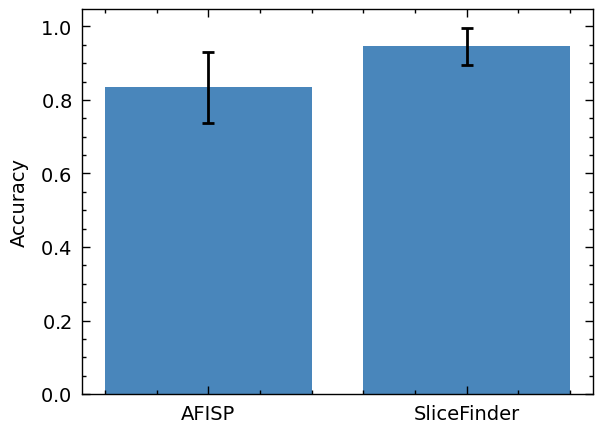

In [84]:

bar_df = deg2_df[["Method", "Accuracy"]].groupby("Method").mean().reset_index()
bar_df = bar_df.query('Method != "Clustering"')
erb = 1.96 * np.sqrt(bar_df.Accuracy * (1-bar_df.Accuracy)/50)
plt.bar(bar_df.Method, p, yerr=err, capsize=2, alpha=0.75)
plt.ylabel('Accuracy')
plt.savefig("fig/simulation_accuracy.pdf", dpi=360)